### 1 - Download data and packages

In [1]:
#! pip install gdown

In [2]:
#!gdown 1-FOGgp3S7NlQeyjuXY7zsvAazTYzCobw

In [3]:
#! sudo apt-get install unzip
#! unzip pascal-voc-dataset-used-in-yolov3-video.zip

In [26]:
! pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [4]:
# pytorch lightnining
! pip install pytorch-lightning --quiet
! pip install lightning-bolts --quiet
! pip install torch_lr_finder --quiet
! pip install albumentations --quiet
! pip install pandas --quiet

from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger,TensorBoardLogger

In [27]:
import config
import torch
import torch.optim as optim
import pandas as pd
import seaborn as sn

from model import YOLOv3
from tqdm import tqdm
from utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples,
)
from loss import YoloLoss
import warnings
warnings.filterwarnings("ignore")
from torch.optim.lr_scheduler import OneCycleLR
import random
import dataset
from torch_lr_finder import LRFinder

### 2 - LR Finder

In [6]:
# LR Finder

# model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
# optimizer = optim.Adam(
#     model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
# )
# loss_fn = YoloLoss()
# scaler = torch.cuda.amp.GradScaler()

# ttrain_dataset,test_dataset,train_eval_dataset, train_loader, test_loader, train_eval_loader  = get_loaders(
#     train_csv_path= "./PASCAL_VOC/train.csv", test_csv_path="./PASCAL_VOC/test.csv"
# )

# scaled_anchors = (
#       torch.tensor(config.ANCHORS)
#     * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
# ).to(config.DEVICE)

# def criterion(out, y):
#     y0, y1, y2 = (
#             y[0].to(config.DEVICE),
#             y[1].to(config.DEVICE),
#             y[2].to(config.DEVICE),
#         )
#     loss = (
#                 loss_fn(out[0], y0, scaled_anchors[0])
#                 + loss_fn(out[1], y1, scaled_anchors[1])
#                 + loss_fn(out[2], y2, scaled_anchors[2])
#             )
#     return loss
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
# lr_finder.plot()  # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

### 2 - Lightning model Yolo3

In [7]:
# custom functions for yolo

# loss function for yolov3
loss_fn = YoloLoss()
def criterion(out, y,anchors):
  loss = (  loss_fn(out[0], y[0], anchors[0])
            + loss_fn(out[1], y[1], anchors[1])
            + loss_fn(out[2], y[2], anchors[2])
            )
  return loss

# accuracy function for yolov3
def accuracy_fn(y, out, threshold,
                correct_class, correct_obj,
                correct_noobj, tot_class_preds,
                tot_obj, tot_noobj):

  for i in range(3):

      obj = y[i][..., 0] == 1 # in paper this is Iobj_i
      noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

      correct_class += torch.sum(
          torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
      )
      tot_class_preds += torch.sum(obj)

      obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
      correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
      tot_obj += torch.sum(obj)
      correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
      tot_noobj += torch.sum(noobj)

  return((correct_class/(tot_class_preds+1e-16))*100,
         (correct_noobj/(tot_noobj+1e-16))*100,
         (correct_obj/(tot_obj+1e-16))*100)

In [8]:
# pytorch lightning
class LitYolo(LightningModule):
    def __init__(self, num_classes=config.NUM_CLASSES, lr=config.LEARNING_RATE,weight_decay=config.WEIGHT_DECAY,threshold=config.CONF_THRESHOLD,my_dataset=None):
        super().__init__()

        self.save_hyperparameters()
        self.model = YOLOv3(num_classes=self.hparams.num_classes)
        self.my_dataset = my_dataset
        self.criterion = criterion
        self.accuracy_fn = accuracy_fn
        #self.scaled_anchors = (torch.tensor(config.ANCHORS) * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
        self.tot_class_preds, self.correct_class = 0, 0
        self.tot_noobj, self.correct_noobj = 0, 0
        self.tot_obj, self.correct_obj = 0, 0
        self.scaled_anchors = 0

    def set_scaled_anchor(self, scaled_anchors):
      self.scaled_anchors = scaled_anchors

    def forward(self, x):
      out = self.model(x)
      return out

    def on_train_epoch_start(self):
      # Set a new image size for the dataset at the beginning of each epoch
      size_idx = random.choice(range(len(config.IMAGE_SIZES)))
      self.my_dataset.set_image_size(size_idx=0)
      self.set_scaled_anchor((
          torch.tensor(config.ANCHORS)
          * torch.tensor(config.S[size_idx]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
      ))

    def on_validation_epoch_start(self):
      self.set_scaled_anchor((
          torch.tensor(config.ANCHORS)
          * torch.tensor(config.S[1]).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
      ))

    def training_step(self, batch, batch_idx):
        x, y = batch
        out  = self(x)
        loss = self.criterion(out,y,self.scaled_anchors)
        acc  = self.accuracy_fn(y,out,self.hparams.threshold,self.correct_class,
                                                                     self.correct_obj,
                                                                     self.correct_noobj,
                                                                     self.tot_class_preds,
                                                                     self.tot_obj,
                                                                     self.tot_noobj)

        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log_dict({"class_accuracy": acc[0], "no_object_accuracy": acc[1], "object_accuracy":acc[2]},prog_bar=True,on_step=False, on_epoch=True)
        return loss


    def evaluate(self, batch, stage=None):
        x, y = batch
        test_out = self(x)
        loss = self.criterion(test_out,y,self.scaled_anchors)
        acc  = self.accuracy_fn(y,test_out,self.hparams.threshold,self.correct_class,
                                                                     self.correct_obj,
                                                                     self.correct_noobj,
                                                                     self.tot_class_preds,
                                                                     self.tot_obj,
                                                                     self.tot_noobj)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log_dict({"class_accuracy": acc[0], "no_object_accuracy": acc[1], "object_accuracy":acc[2]},prog_bar=True)

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = OneCycleLR(
                optimizer,
                max_lr= 1E-2,
                pct_start = 5/self.trainer.max_epochs,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=len(train_loader),
                div_factor=100,verbose=True,
                three_phase=False
            )
        return ([optimizer],[scheduler])

### 3 - Train model

In [16]:
train_dataset,test_dataset,train_eval_dataset, train_loader, test_loader, train_eval_loader = get_loaders(train_csv_path="./PASCAL_VOC/train.csv", test_csv_path="./PASCAL_VOC/test.csv")

In [17]:
model = LitYolo(my_dataset = train_dataset)
trainer = Trainer(log_every_n_steps=1,
                  check_val_every_n_epoch=1,
    enable_model_summary=True,
    max_epochs=40,
    precision=16,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger= [CSVLogger(save_dir="logs/"), TensorBoardLogger("logs/", name="YoloV3")],
    default_root_dir="model/save/",
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model, train_loader,test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | YOLOv3 | 61.6 M
---------------------------------
61.6 M    Trainable params
0         Non-trainable params
61.6 M    Total params
123.253   Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-04.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0001e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0001e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0001e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0001e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0002e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0002e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0003e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0003e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0004e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0004e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0005e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0006e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0007e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0007e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0008e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0009e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0010e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0011e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0012e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0013e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0014e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0015e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0017e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0018e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0019e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0021e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0022e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0023e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0025e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0026e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0028e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0030e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0031e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0033e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0035e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0037e-04.


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [19]:
trainer.validate(model, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     class_accuracy          79.15924072265625
   no_object_accuracy        98.18472290039062
     object_accuracy         57.45027542114258
        val_loss             6.412050247192383
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 6.412050247192383,
  'class_accuracy': 79.15924072265625,
  'no_object_accuracy': 98.18472290039062,
  'object_accuracy': 57.45027542114258}]

In [13]:
DIV = 32
IMAGE_SIZES = [320, 416, 416, 416, 608, 608]
S = [[x//DIV, x//DIV*2, x//DIV*4] for x in IMAGE_SIZES]
S

[[10, 20, 40],
 [13, 26, 52],
 [13, 26, 52],
 [13, 26, 52],
 [19, 38, 76],
 [19, 38, 76]]

### 4 - Save Checkpoint

In [20]:
trainer.save_checkpoint("yolo3_model_multi.ckpt")

,lr-Adam,val_loss,class_accuracy,no_object_accuracy,object_accuracy,train_loss
epoch,,,,,,
NaN,0.0001,NaN,NaN,NaN,NaN,NaN
NaN,0.0001,NaN,NaN,NaN,NaN,NaN
NaN,0.0001,NaN,NaN,NaN,NaN,NaN
NaN,0.0001,NaN,NaN,NaN,NaN,NaN
NaN,0.0001,NaN,NaN,NaN,NaN,NaN


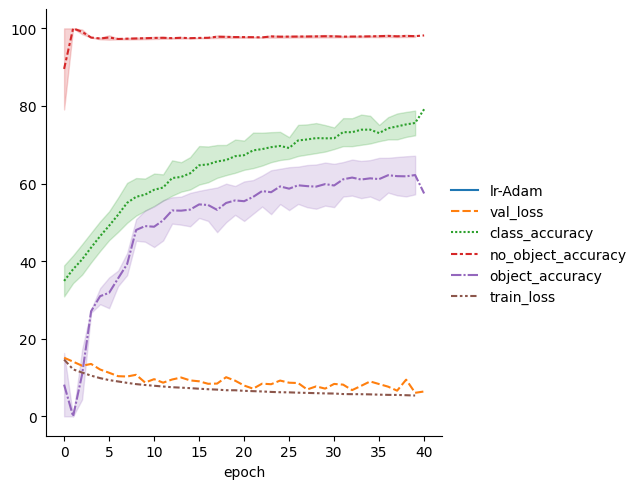

In [28]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")